# Cavity propagation notebook

This notebook propagates a wavefront through a simple optical cavity.
The initial wavefront wfrCenter0 is a Hermite-Gaussian mode located at the center of the cavity. 
Next, the wavefront is propagated a distance Lc/2 where Lc is the cavity length. 

We continue by passing the wavefront through a thin lens with focal length Lc/4 + dfR. dfR$\neq0$ allows for a focusing error in the right mirror
mirror. It can be both positive and negative. The wavefront passes through a lens again with focal length Lc/4 + dfL. We now repeat N times.

We construct a list of all the wavefronts called cavitywfrList. These are propagated through the sections of the cavity. After the propagation, the wavefronts can be visualized at the three locations: center, right mirror, and left mirror.

A Sirepo/SRW simulation with comparable parameters is available at https://www.sirepo.com/srw#/beamline/MVQGzoQ2

In [1]:
#Import necessary libraries
from __future__ import print_function #Python 2.7 compatibility
import rslaser.rsoptics
from rslaser.rsoptics.wavefront import *
from srwl_uti_dataProcess import *
%load_ext autoreload
%autoreload 2
import numpy as np
import math
import os 
import sys
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.ndimage
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}

In [2]:
#Specify parameters for simulation
Lc = 10 #Length of cavity [m]
dfR = 0
dfL = 0
sigmaRCenter0 = 0.2e-3 #Initial RMS beam size at center of cavity [m]
propLen=15 #Propagation of initial Gaussian [m]. It will then be back-propagated by propLen: a trick to get the Gaussian mode at the waist
pulseE = .001 #Total energy of pulse [eV]
mx = 0 #Horizontal mode number (0 for Gaussian)
my = 0 #Vertical mode number (0 for Gaussian)
poltype = 1 #Polarization of mode (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
wavefrontEnergy = 1.55 #Wavefront Energy [eV]. 1.55 eV is 800 nm wavelength
sampFact = 15 #Determines grid size of initial wavefront


In [3]:
#Now we construct the initial wavefront at the center of cavity
#wfr0=createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my)
wfrCenter0=createGsnSrcSRW(sigmaRCenter0,propLen,pulseE,poltype,wavefrontEnergy,sampFact,mx,my) #creates Gaussian wavefront in SRW
(nx0,ny0)=(wfrCenter0.mesh.nx,wfrCenter0.mesh.ny)
print("Initial wavefront calculated on a grid of %d x %d points" %(nx0,ny0))

Initial wavefront calculated on a grid of 2912 x 2912 points


In [4]:
#Now build the different beamline elements we need to propagate to the right and to the left
propagateRight = createDriftLensBL(Lc,dfR)
propagateLeft = createDriftLensBL(Lc,dfL)
propagateDrift = createDriftBL(Lc)

In [5]:
#Now construct a list of wavefront objects starting with initial wavefront wfrCenter0

cavitywfrList = [wfrCenter0]
    
npass = 4    
#Now run through beamline and propagate wavefronts
for i in range(npass):
    wfr = deepcopy(cavitywfrList[-1])
    srwl.PropagElecField(wfr, propagateRight)
    cavitywfrList.append(wfr)
    wfr2 = deepcopy(wfr)
    srwl.PropagElecField(wfr2,propagateDrift)
    cavitywfrList.append(wfr2)
    wfr3 = deepcopy(wfr2)
    srwl.PropagElecField(wfr3, propagateLeft)
    cavitywfrList.append(wfr3)
    wfr4 = deepcopy(wfr3)
    srwl.PropagElecField(wfr4, propagateDrift)
    cavitywfrList.append(wfr4)

    


In [6]:
#Check the rms sizes along the way.
for j in range(np.size(cavitywfrList)):
    (sx,sy) = rmsWavefrontIntensity(cavitywfrList[j])
    print(sx,sy)

0.00020256243087884252 0.0002025624399396569
0.001601650068424116 0.001605119619233149
0.00020261008751786572 0.00020304652660766169
0.0016973802320471578 0.0017047414630518034
0.00020363668144267666 0.00020449777851518577
0.0018750107846831397 0.0018870812882470975
0.000204298979194028 0.00020559198358556117
0.0021133530370150005 0.0021311346430043228
0.00020774689372923507 0.0002091984459156665
0.0023950281253993454 0.0024195653050149333
0.00021590790073707322 0.00021772004255763599
0.002707106396475216 0.002739180308594627
0.0002957807725113489 0.0002972455665186378
0.0030574823294240564 0.0030969784401185065
0.0004574431474820927 0.0004575622672818631
0.00348835049426017 0.003536512914723979
0.0028552310518595476 0.002862107395448425


Size of initial wavefront data array (coordinate): (2912, 2912)


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


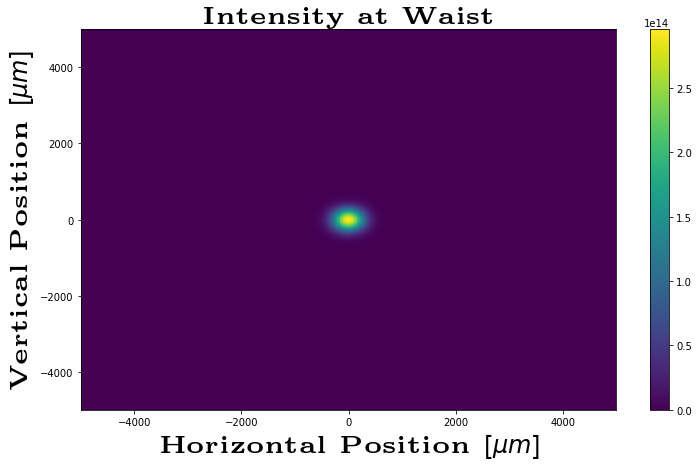

In [7]:
# Plot initial wavefront
##Initial wfr calculation
wavefrontToPlot = 0 #This can range from 0 to 3*npass
wfrplot = cavitywfrList[wavefrontToPlot] 

arIinit = array('f', [0]*wfrplot.mesh.nx*wfrplot.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfrplot, 6, 0, 3, wfrplot.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfrplot.mesh.nx, wfrplot.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfrplot.mesh.xStart,wfrplot.mesh.xFin,wfrplot.mesh.nx)
yvalsf02=np.linspace(wfrplot.mesh.yStart,wfrplot.mesh.yFin,wfrplot.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis)  ##By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.colorbar()
#['Horizontal Position [mm]', , 'Intensity']
xmax = 5e3
ymax = 5e3
ax.set_ylim(-ymax,ymax)
ax.set_xlim(-xmax,xmax)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)
plt.show()